<a href="https://colab.research.google.com/github/dpanagop/data_analytics_examples/blob/master/UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examples of UMAP

This notebook contains examples of UMAP applications. It is divided in two parts. The first one is based on Iris dataset. Here we will use UMAP to 
- embed the Iris datast to a plane,
- create a classifier for predicting labels (species) of datapoints,
- use supervision to embed the Iris datast to a plane.

 The second part is based on a small sample of Wikipedia articles. Here we will use UMAP to cluster the articles corpus. 


We begin by installing UMAP library

In [ ]:
pip install umap-learn

     |████████████████████████████████| 80 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 21.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=4f896cfdafe805020eb0bfd043746d43a9c3175622548b625dc0a2307f02e150
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=5d03dcc7c0e023e42042e9ff78c5113880573c33afdd4aef5396a747b2d025ac
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


Then we load necessary Python libraries

In [ ]:
import numpy as np
from sklearn.datasets import load_iris,load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline

## Iris data set

Load the dataset into a table and preview its first rows.

In [ ]:
iris_data = load_iris().data
iris_labels = load_iris().target
iris = pd.DataFrame(iris_data,columns=['sepal_length',  'sepal_width','petal_length','petal_width'])
iris_labels_str = [ (lambda x: 'setosa' if x==0 else ('versicolor' if x==1 else 'virginica'))(x) for x in iris_labels]
iris['species']=iris_labels_str
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Using seaborn we can create two dimensional scatterplots.

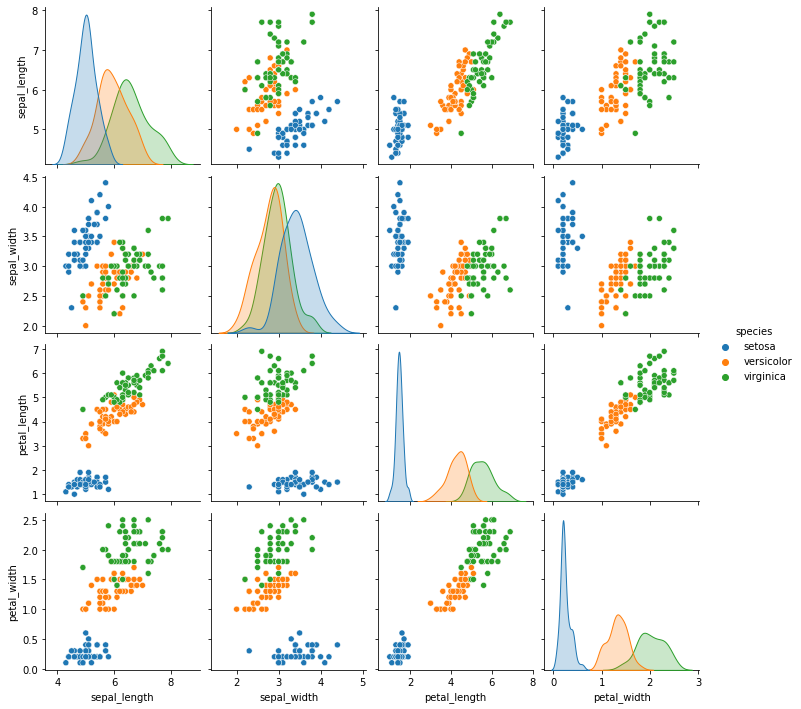

In [ ]:
sns.pairplot(iris, hue='species')

For all the applications that will follow we are going to work on a Normalized version of the dataset.

In [ ]:
iris_scaled =StandardScaler().fit_transform(iris.iloc[:,0:4])

### Just embeding

In [ ]:
embedding = umap.UMAP().fit_transform(iris_scaled)
embedding.shape

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(150, 2)

Text(0.5, 1.0, 'UMAP projection of the Iris dataset')

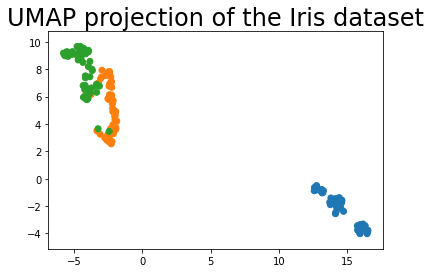

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in iris['species'].map({'setosa':0, 'versicolor':1, 'virginica':2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Iris dataset', fontsize=24)

### For predicting

Split into train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris_data,
                                                    iris_labels,
                                                    stratify=iris_labels,
                                                    random_state=42)

In [ ]:
scale_model=StandardScaler().fit(X_train)
X_train_scaled=scale_model.transform(X_train)
X_test_scaled=scale_model.transform(X_test)

In [ ]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(X_train_scaled)

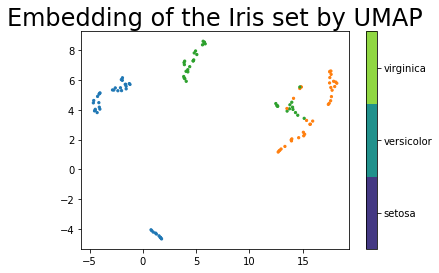

In [ ]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=[sns.color_palette()[x] for x in y_train], cmap='Spectral')
plt.title('Embedding of the Iris set by UMAP', fontsize=24)
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(['setosa','versicolor','virginica'])

We have used the training set to create an embeding function f(x):$R^4\rightarrow R^2$. 

This function $f(x)$ will be used to map the test set to $R^2$. Then k-nearest neighbours algorithm will be executed on the embeding space to predict the labels of the test set.

In [ ]:
test_embedding = trans.transform(X_test_scaled)

Execute k-nearest neighbours algorithm in embeding space.

In [ ]:
# train/fit
knn = KNeighborsClassifier().fit(trans.embedding_, y_train)

In [ ]:
# predict
prediction = knn.predict(test_embedding)

The results can be seen in the following cross table.

In [ ]:
cross_tab= pd.DataFrame({'actual':[ (lambda x: 'setosa' if x==0 else ('versicolor' if x==1 else 'virginica'))(x) for x in y_test],
                         'predicted':[ (lambda x: 'setosa' if x==0 else ('versicolor' if x==1 else 'virginica'))(x) for x in prediction]
                         })
cross = pd.crosstab(index=cross_tab['actual'], 
                             columns=cross_tab['predicted'],
                             margins=False)

cross

predicted,setosa,versicolor,virginica
actual,,,
setosa,12,0,0
versicolor,0,13,0
virginica,0,2,11


In [ ]:
cross/cross.sum().sum()

predicted,setosa,versicolor,virginica
actual,,,
setosa,0.315789,0.000000,0.000000
versicolor,0.000000,0.342105,0.000000
virginica,0.000000,0.052632,0.289474


In [ ]:
print(classification_report(y_test, prediction,target_names=['target_names=setosa','versicolor','virginica']))

                     precision    recall  f1-score   support

target_names=setosa       1.00      1.00      1.00        12
         versicolor       0.87      1.00      0.93        13
          virginica       1.00      0.85      0.92        13

           accuracy                           0.95        38
          macro avg       0.96      0.95      0.95        38
       weighted avg       0.95      0.95      0.95        38



### Supervised embeding

We can use available labels in the train set to perform a supervised embeding. Then this new embeding can be used for classifing the test set.

In [ ]:
trans_sup = umap.UMAP(n_neighbors=5, random_state=42).fit(X_train_scaled,y=y_train)

Text(0.5, 1.0, 'Embedding by UMAP')

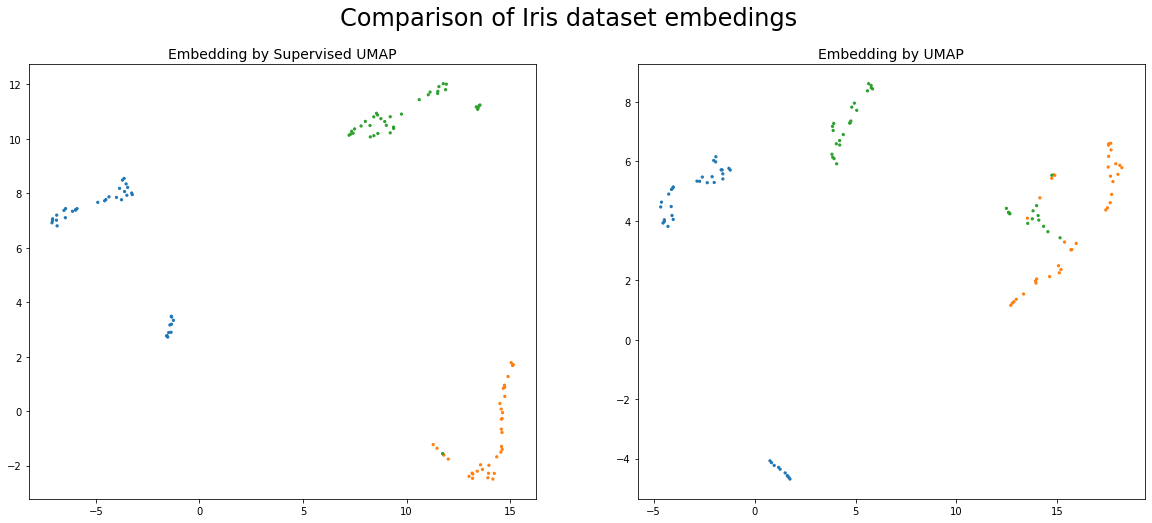

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
fig.suptitle('Comparison of Iris dataset embedings', fontsize=24)
ax1.scatter(trans_sup.embedding_[:, 0], trans_sup.embedding_[:, 1], s= 5, c=[sns.color_palette()[x] for x in y_train], cmap='Spectral')
ax1.set_title('Embedding by Supervised UMAP', fontsize=14)
ax2.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=[sns.color_palette()[x] for x in y_train], cmap='Spectral')
ax2.set_title('Embedding by UMAP', fontsize=14)

From the graph above, it seems that the use of supervised version of UMAP performs better in seperating the three different species in the embeding space. 

In [ ]:
test_embedding_sup = trans_sup.transform(X_test_scaled)
# train/fit
knn = KNeighborsClassifier().fit(trans_sup.embedding_, y_train)
# predict
prediction = knn.predict(test_embedding_sup)

cross_tab= pd.DataFrame({'actual':[ (lambda x: 'setosa' if x==0 else ('versicolor' if x==1 else 'virginica'))(x) for x in y_test],
                         'predicted':[ (lambda x: 'setosa' if x==0 else ('versicolor' if x==1 else 'virginica'))(x) for x in prediction]
                         })
cross = pd.crosstab(index=cross_tab['actual'], 
                             columns=cross_tab['predicted'],
                             margins=False)

cross

predicted,setosa,versicolor,virginica
actual,,,
setosa,12,0,0
versicolor,0,13,0
virginica,0,3,10


In [ ]:
print(classification_report(y_test, prediction,target_names=['target_names=setosa','versicolor','virginica']))

                     precision    recall  f1-score   support

target_names=setosa       1.00      1.00      1.00        12
         versicolor       0.81      1.00      0.90        13
          virginica       1.00      0.77      0.87        13

           accuracy                           0.92        38
          macro avg       0.94      0.92      0.92        38
       weighted avg       0.94      0.92      0.92        38



But the performance of the classifier on the test set is worse. A posible indication of overfitting.

##Wikipedia articles clustering

###Download articles with wikipedia package

In [ ]:
!pip install wikipedia

In [ ]:
import wikipedia
articles=['Data Science','Artificial intelligence','machine learning','Deep Learning','Artificial_neural_network','k-means clustering','Cluster analysis',
          'BERT (language model)','Transformer (machine learning model)',
          'European Central Bank','Bank','Financial technology','International Monetary Fund','U.S. Securities and Exchange Commission','Federal Reserve',
          'Bank of England','Bank of Greece','Deutsche Bundesbank','Peoples Bank of China',
          'Currency','Spanish dinero','Canadian dollar','United States dollar','Euro','Bitcoin','Litecoin','Ripple (payment protocol)','Ethereum',
          'Basketball','Swimming','Tennis','Cricket','Baseball','Cycle sport','Golf','Ice hockey','Speed skating','Curling','Badminton','Beach volleyball',
          'Water volleyball','Volleyball','Beach tennis',
          'Athens','Panathinaikos A.O.','Olympiacos CFP','Greece','Madrid','Barcelona','Spain','Barcelona S.C.','Real Madrid CF','Manchester','Manchester United F.C.','Manchester City F.C.',
          'Arsenal','Arsenal F.C.','Premier League','United Kingdom','United States']
wiki_lst=[]
title=[]
for article in articles:
    print("loading content: ",article)
    wiki_lst.append(wikipedia.page(article,auto_suggest=False).content)
    title.append(article)

loading content:  Data Science
loading content:  Artificial intelligence
loading content:  machine learning
loading content:  Deep Learning
loading content:  Artificial_neural_network
loading content:  k-means clustering
loading content:  Cluster analysis
loading content:  BERT (language model)
loading content:  Transformer (machine learning model)
loading content:  European Central Bank
loading content:  Bank
loading content:  Financial technology
loading content:  International Monetary Fund
loading content:  U.S. Securities and Exchange Commission
loading content:  Federal Reserve
loading content:  Bank of England
loading content:  Bank of Greece
loading content:  Deutsche Bundesbank
loading content:  Peoples Bank of China
loading content:  Currency
loading content:  Spanish dinero
loading content:  Canadian dollar
loading content:  United States dollar
loading content:  Euro
loading content:  Bitcoin
loading content:  Litecoin
loading content:  Ripple (payment protocol)
loading con

###TD-IDF vectorizer from sklearn

We will use TD-IDF vectorizer from sklearn to transform the corpus into a numerical matrix.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(wiki_lst)
print(X.shape)

(60, 25405)


###Clustering with UMAP and KMeans

Note that as stated in [UMAP's documentation on clustering](https://umap-learn.readthedocs.io/en/latest/clustering.html):

> One advantage of UMAP for this is that it doesn’t require you to reduce to only two dimensions – you can reduce to 10 dimensions instead since the goal is to cluster, not visualize, and the performance cost with UMAP is minimal.

>...when using UMAP for dimension reduction you will want to select different parameters than if you were using it for visualization. 

>First of all we will  want **a larger n_neighbors value** – small values will focus more on very local structure and are more prone to producing fine grained cluster structure that may be more a result of patterns of noise in the data than actual clusters. In
this case we’ll double it from the default 15 up to 30.

>Second it is beneficial to **set min_dist to a very low value**. Since we actually want to pack points together densely (density is what we want after all) a low value will help, as well as making cleaner separations between clusters. In this case we will simply set min_dist to be 0.


In [ ]:
clusterable_embedding = umap.UMAP(n_neighbors=3,
                                  min_dist=0.0,
                                  n_components=2,
                                  random_state=42,).fit_transform(X)

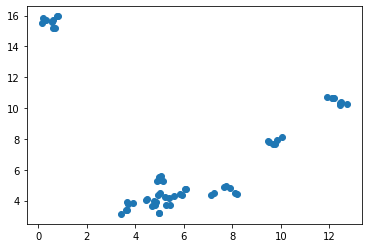

In [ ]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            cmap='Spectral');

The embeding above displays a well defined group on the upper left corner. Two small groups on the right and one or two groups at the midle bottom.

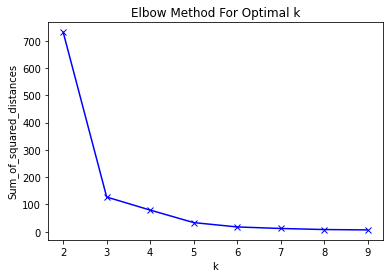

In [ ]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(clusterable_embedding)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow method suggests that we have 3 clusters. A second choice would be 5 clusters.

If we try with 3 clusters, we have the following.

In [ ]:
k = 3
model = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=10)
model.fit(clusterable_embedding)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                                      title  cluster
29                                 Swimming        0
25                                 Litecoin        0
26                Ripple (payment protocol)        0
27                                 Ethereum        0
58                           United Kingdom        0
31                                  Cricket        0
32                                 Baseball        0
33                              Cycle sport        0
35                               Ice hockey        0
36                            Speed skating        0
37                                  Curling        0
43                                   Athens        0
44                       Panathinaikos A.O.        0
45                           Olympiacos CFP        0
46                                   Greece        0
47                                   Madrid        0
48                                Barcelona        0
49                                    Spain   

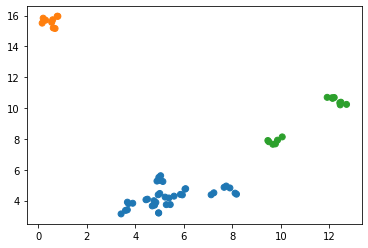

In [ ]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=[sns.color_palette()[x] for x in labels],# s=0.1,
            cmap='Spectral');

Cluster: 0
Titles
                   European Central Bank
                                    Bank
                    Financial technology
             International Monetary Fund
 U.S. Securities and Exchange Commission
                         Federal Reserve
                         Bank of England
                          Bank of Greece
                     Deutsche Bundesbank
                   Peoples Bank of China
                                Currency
                          Spanish dinero
                         Canadian dollar
                    United States dollar
                                    Euro
                                 Bitcoin
                                Litecoin
               Ripple (payment protocol)
                                Ethereum
                                Swimming
                                 Cricket
                                Baseball
                             Cycle sport
                              Ice hocke

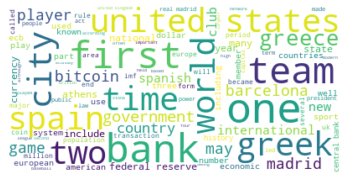

Cluster: 1
Titles
                         Data Science
              Artificial intelligence
                     machine learning
                        Deep Learning
            Artificial_neural_network
                   k-means clustering
                     Cluster analysis
                BERT (language model)
 Transformer (machine learning model)


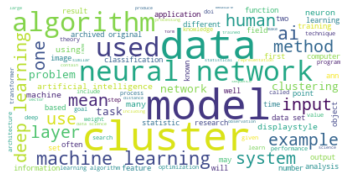

Cluster: 2
Titles
             Basketball
                 Tennis
                   Golf
              Badminton
       Beach volleyball
       Water volleyball
             Volleyball
           Beach tennis
             Manchester
 Manchester United F.C.
   Manchester City F.C.
                Arsenal
           Arsenal F.C.
         Premier League


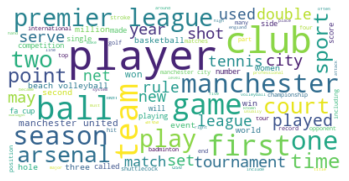

In [ ]:
from wordcloud import WordCloud
result={'cluster':labels,'wiki':wiki_lst}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=wiki_cl[wiki_cl.cluster==k]['title']
    print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
df=pd.DataFrame({'x_cord':clusterable_embedding[:, 0], 'y_cord':clusterable_embedding[:, 1],'labels':labels,'title':title})
df['labels'] = df['labels'].astype(str)

In [ ]:
df.head()

,x_cord,y_cord,labels,title
0,0.166490,15.514628,1,Data Science
1,0.208493,15.835050,1,Artificial intelligence
2,0.308023,15.706084,1,machine learning
3,0.599421,15.732163,1,Deep Learning
4,0.558709,15.567245,1,Artificial_neural_network


In [ ]:
import plotly.express as px
#from IPython.display import HTML

#fig = px.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], color=labels,hover_name=title, width=1000, height=800)
fig = px.scatter(df, x='x_cord',y='y_cord',color='labels', hover_name='title',width=1000, height=800)
fig.show()
# HTML(fig.to_html())


Below we try different parameters for UMAP.

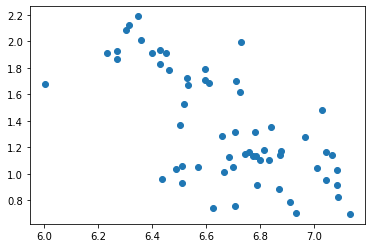

In [ ]:
clusterable_embedding = umap.UMAP(n_neighbors=15,
                                  min_dist=0.0,
                                  n_components=10,
                                  random_state=42,).fit_transform(X)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            cmap='Spectral')

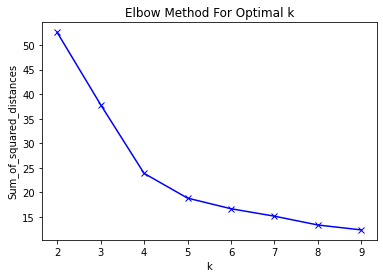

In [ ]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(clusterable_embedding)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
k = 4
model = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=10)
model.fit(clusterable_embedding)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                                      title  cluster
29                                 Swimming        0
49                                    Spain        0
33                              Cycle sport        0
58                           United Kingdom        0
27                                 Ethereum        0
26                Ripple (payment protocol)        0
25                                 Litecoin        0
24                                  Bitcoin        0
23                                     Euro        0
22                     United States dollar        0
21                          Canadian dollar        0
20                           Spanish dinero        0
19                                 Currency        0
18                    Peoples Bank of China        0
17                      Deutsche Bundesbank        0
16                           Bank of Greece        0
59                            United States        0
14                          Federal Reserve   

In [ ]:
df=pd.DataFrame({'x_cord':clusterable_embedding[:, 0], 'y_cord':clusterable_embedding[:, 1],'labels':labels,'title':title})
df['labels'] = df['labels'].astype(str)

import plotly.express as px
#from IPython.display import HTML

#fig = px.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], color=labels,hover_name=title, width=1000, height=800)
fig = px.scatter(df, x='x_cord',y='y_cord',color='labels', hover_name='title',width=1000, height=800)
fig.show()
# HTML(fig.to_html())


### Classical k-means on TF-IDF

As a baseline, we use k-means on the TF-IDF matrix directly.

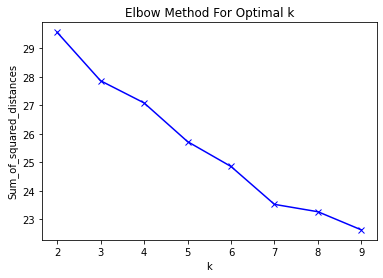

In [ ]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                                      title  cluster
29                                 Swimming        0
55                                  Arsenal        0
19                                 Currency        0
20                           Spanish dinero        0
21                          Canadian dollar        0
22                     United States dollar        0
23                                     Euro        0
27                                 Ethereum        1
58                           United Kingdom        1
43                                   Athens        1
46                                   Greece        1
47                                   Madrid        1
48                                Barcelona        1
49                                    Spain        1
52                               Manchester        1
18                    Peoples Bank of China        1
17                      Deutsche Bundesbank        1
59                            United States   